### Libraries

Below are the libraries used. These were selected to be compatible with both Python 2.x and 3.x.

In [2]:
import math
import glob2
import numpy as np
import cv2
import pickle
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from shapely.geometry import Polygon
import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import *
from IPython.display import HTML
%matplotlib inline


### Classifier

The classifier is based on a mixture of hue/saturation features from the HLS color space, spatially binned features and HOG features.  The data set is the entirety of the provided data set for the assignment.  You can see in the `compute_spatial_hls_hog` method some ideas on reducing the feature vector to those features with the most significant contributions as noted from the `feature_importances_` property of the decision tree classifier.  Reducing the feature space introduced false-positives, so I did not end up using that approach for the final output.  The graph below is the `feature_importances_` graph for the feature data used in the resulting video.  The the numeric values are the accuracies of the classifiers against the test data set: SVM, decision tree, and the combination.  I save the entire `Classifier` class as a `pickle` object so that I can load it easier in the next steps.

[ 0.99837486  0.96830986  0.98239437]


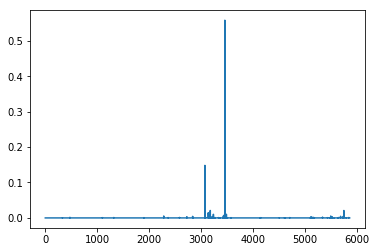

In [3]:
class Classifier:

    IMAGE_SIZE = (64, 64)
    
    SPATIAL_SIZE = (32, 32)
    
    HOG_ORIENTATIONS = 9
    HOG_PIXELS_PER_CELL = (8,8)
    HOG_CELLS_PER_BLOCK = (2,2)
    
    HLS_BINS = 512 
    HLS_BIN_RANGE = (0,255)
    
    SVC_KERNEL = 'rbf'
    SVC_C_VALUE = 2.0
    
    DT_MIN_SAMPLES_SPLIT = 40
    
    TEST_FRACTION = 0.2
    RANDOM_STATE = 12345
    
    PICKLE_FILE = 'classifier.p'
    
    def __init__(self, true_path, false_path):
        self.true_path = true_path
        self.false_path = false_path
        
    def get_recursive_paths(self, path_def):
        return glob2.glob(path_def)

    def load_image(self, filename):
        image = mpimg.imread(filename)
        return cv2.resize(image, self.IMAGE_SIZE) 

    def spatial_bins(self, image):
        return cv2.resize(image, self.SPATIAL_SIZE).ravel() 
    
    def hls_bins(self, image):
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        h_hist = np.histogram(hls[:,:,0], bins=self.HLS_BINS, range=self.HLS_BIN_RANGE)
        s_hist = np.histogram(hls[:,:,2], bins=self.HLS_BINS, range=self.HLS_BIN_RANGE)
        return np.concatenate((h_hist[0], s_hist[0]))
    
    def hog_bins(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        return hog(gray, orientations=self.HOG_ORIENTATIONS, pixels_per_cell=self.HOG_PIXELS_PER_CELL, cells_per_block=self.HOG_CELLS_PER_BLOCK, transform_sqrt=True, visualise=False, feature_vector=True)
        
    def compute_spatial_hls_hog(self, image):
        spatial = self.spatial_bins(image)
        hls = self.hls_bins(image)
        hog = self.hog_bins(image)
        total = np.concatenate((spatial, hls, hog))
        #total = np.concatenate((total[250:1300], total[2300:2500], total[3100:3600]))
        return total
    
    def normalize(self, data):
        data=np.array(data, np.float32)
        self.scaler = StandardScaler().fit(data)
        scaled_data = self.scaler.transform(data)
        return scaled_data
    
    def train(self):
        self.svc_classifier = SVC(kernel=self.SVC_KERNEL,C=self.SVC_C_VALUE)
        self.svc_classifier.fit(self.training_features, self.training_labels)
        self.dt_classifier = DecisionTreeClassifier(min_samples_split=self.DT_MIN_SAMPLES_SPLIT)
        self.dt_classifier.fit(self.training_features, self.training_labels)
        return self
        
    def combine(self, list_a, list_b):
        result = []
        for idx, val_a in enumerate(list_a):
            val_b = list_b[idx]
            if val_a == 1.0 or val_b == 1.0:
                result.append(1.0)
            else:
                result.append(0.0)
        return result
        
    def test(self):
        svc_prediction = self.svc_classifier.predict(self.testing_features)
        svc_accuracy = accuracy_score(svc_prediction, self.testing_labels)
        dt_prediction = self.dt_classifier.predict(self.testing_features)
        dt_accuracy = accuracy_score(dt_prediction, self.testing_labels)
        composite_prediction = self.combine(svc_prediction, dt_prediction)
        composite_accuracy = accuracy_score(composite_prediction, self.testing_labels)
        return np.array([svc_accuracy, dt_accuracy, composite_accuracy])
        
    def classify_new(self, image):
        image = cv2.resize(image, self.IMAGE_SIZE)
        data = self.compute_spatial_hls_hog(image)
        data = self.scaler.transform(data)
        svc_prediction = self.svc_classifier.predict(data)
        dt_prediction = self.dt_classifier.predict(data)
        composite_prediction = self.combine(svc_prediction, dt_prediction)
        return np.array([svc_prediction, dt_prediction, composite_prediction])
        
    def load(self):
        features = []
        labels = []
        true_paths = self.get_recursive_paths(self.true_path)
        for filename in true_paths:
            image = self.load_image(filename)
            hls_hog = self.compute_spatial_hls_hog(image)
            features.append(hls_hog)
            labels.append(1.0)
        false_paths = self.get_recursive_paths(self.false_path) 
        for filename in false_paths:
            image = self.load_image(filename)
            hls_hog = self.compute_spatial_hls_hog(image)
            features.append(hls_hog)
            labels.append(0.0)
        features = self.normalize(features)
        self.training_features, self.testing_features, self.training_labels, self.testing_labels = train_test_split(features, labels, test_size=self.TEST_FRACTION, random_state=self.RANDOM_STATE)
        self.training_labels = np.array(self.training_labels, np.float32)
        self.testing_labels = np.array(self.testing_labels, np.float32)
        return self
    
    def save_classifier(self):
        pickle.dump(self, open(self.PICKLE_FILE, 'wb'))
        
        
classifier = Classifier('vehicles/**/*.png', 'non-vehicles/**/*.png')        
print(classifier.load().train().test())
plt.plot(classifier.dt_classifier.feature_importances_)
classifier.save_classifier()

### Proportional Steps 

This class is used to generate proportional steps between a starting and stopping point.  It is used in the next class to generate the tilings, both as a vertical and horizontal iterator.

In [7]:
class ProportionalStepScaler:
    
    def __init__(self, start_point, stop_point, start_size, stop_size, overlap):
        self.start_point = start_point
        self.stop_point = stop_point
        self.start_size = start_size
        self.stop_size = stop_size
        self.overlap = overlap
        self.size_slope = float(self.stop_size - self.start_size) / float(self.stop_point - self.start_point)
        
    def compute(self):
        result = []
        i = self.start_point + self.start_size / 2
        size = self.start_size
        while i < self.stop_point - self.stop_size / 2:
            result.append((int(i),int(size)))
            size = int(self.start_size + (i - self.start_point) * self.size_slope)
            i = int(i + size * (1 - self.overlap))
        return result
    

### Window Tiling

This class uses the previous class to generate the tilings.  It takes into account the region of interest contour and checks that there is intersection of the tiled sub-frame before allowing it as a valid sub-frame.

In [8]:
class WindowTiling:
    
    def __init__(self, image, mask_region, top_size, bottom_size, overlap):
        self.poly = Polygon(mask_region)
        roi = np.array(mask_region)
        self.image = self.region_of_interest(image, roi)
        self.top_size = top_size
        self.bottom_size = bottom_size
        self.overlap = overlap
        self.left = np.amin(roi, axis=0)[0]
        self.right = np.amax(roi, axis=0)[0]
        self.top = np.amin(roi, axis=0)[1]
        self.bottom = np.amax(roi, axis=0)[1]
        
    def region_of_interest(self, img, vertices):
        mask = np.zeros_like(img)   
        if len(img.shape) > 2:
            channel_count = img.shape[2]  
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255
        cv2.fillPoly(mask, [vertices], ignore_mask_color)
        return cv2.bitwise_and(img, mask)
  
    def vertical_enumeration(self):
        pss = ProportionalStepScaler(self.top, self.bottom, self.top_size, self.bottom_size, self.overlap) 
        return pss.compute()
        
    def horizontal_enumeration(self, size):
        pss = ProportionalStepScaler(self.left, self.right, size, size, self.overlap) 
        return pss.compute()
        
    def generate_regions(self):
        result = []
        vertical = self.vertical_enumeration()
        for v in vertical:
            horizontal = self.horizontal_enumeration(v[1])
            for h in horizontal:
                center = (h[0], v[0])
                size = (h[1], v[1])
                result.append((center, size))
        return result
    
    def generate_images(self):
        result = []
        regions = self.generate_regions()
        for r in regions:
            center = r[0]
            size = r[1]
            left = int(center[1] - size[1]/2)
            right = int(center[1] + size[1]/2)
            top = int(center[0] - size[0]/2)
            bottom = int(center[0] + size[0]/2)
            poly = ((bottom,left), (top,left), (top,right), (bottom,right))
            poly = Polygon(poly)
            intersects = poly.intersects(self.poly)
            if intersects:
                sub_image = self.image[left:right,top:bottom]
                result.append((center, size, sub_image))
        return result
    

### Heat Maps

This class generates two types of heat map overlays: monochromatic intensity only, and color.  The overlays are added to the underlying images in other code.

In [9]:
class HeatMap:
    
    def __init__(self, image):
        self.image = np.array(image)
        self.height = self.image.shape[0]
        self.width = self.image.shape[1]
    
    def mono_overlay(self, points, radius, intensity):
        k_size = 3 * radius
        kernel = np.ones((k_size, k_size), np.float32) / (k_size**2)
        overlay = np.zeros((self.height, self.width), np.uint8)
        for p in points:
            p = (int(p[0]), int(p[1]))
            ol = np.zeros((self.height, self.width), np.uint8)
            cv2.circle(ol, p, radius, intensity, -1)
            ol = cv2.filter2D(ol, -1, kernel)
            cv2.addWeighted(ol, 1.0, overlay, 1.0, 0, overlay)
        return overlay
    
    def color_overlay(self, points, radius, color):
        k_size = 3 * radius
        kernel = np.ones((k_size, k_size), np.float32) / (k_size**2)
        overlay = np.zeros((self.height, self.width, 3), np.uint8)
        for p in points:
            p = (int(p[0]), int(p[1]))
            ol = np.zeros((self.height, self.width, 3), np.uint8)
            cv2.circle(ol, p, radius, color, -1)
            ol = cv2.filter2D(ol, -1, kernel)
            cv2.addWeighted(ol, 1.0, overlay, 1.0, 0, overlay)
        return overlay


### Processing Still Images

This class processes a still image.  It defines the masking region for the tiling, the size of the top and bottom tilings, how much overlap, etc.  It loads the classifier from the `pickle` file to make it faster to iterate over some of these hyperparameters in developing it.  The only thing it can do to the final frame is contribute the heat map for the particular frame.  The temporal aspect of the heat map for detection and the vehicle tracking is done at a level beyond this class.

In [10]:
class StillImage:
    
    MASK_REGION = ( (750,600), (750,400), (1280,400), (1280,600) )
    
    TOP_SIZE = 70
    BOTTOM_SIZE = 150  
    OVERLAP = 0.92
    
    VEHICLES = 'vehicles/**/*.png'
    NON_VEHICLES = 'non-vehicles/**/*.png'
    
    PICKLE_FILE = 'classifier.p'
    
    def load_classifier(self):
        self.classifier = pickle.load(open(self.PICKLE_FILE, 'rb'))
        
    def load_file(self, filename):
        self.image = mpimg.imread(filename)
        
    def load_image(self, image):
        self.image = image
        
    def get_image(self):
        return self.image
        
    def swap(self, data):
        return (data[1], data[0])
        
    def car_points(self):
        wt = WindowTiling(self.image, self.MASK_REGION, self.TOP_SIZE, self.BOTTOM_SIZE, self.OVERLAP)
        windows = wt.generate_images()
        points = []
        for w in windows:
            center = self.swap(w[0])
            bounds = w[1]
            ll = (int(center[0] - bounds[0] / 2), int(center[1] - bounds[1] / 2))
            ur = (int(center[0] + bounds[0] / 2), int(center[1] + bounds[1] / 2))
            corners = (ll, ur)
            image = w[2]
            is_car = self.classifier.classify_new(image)
            if is_car[2] == 1.0:
                points.append((center, corners))
        return points
    
    def get_region_centers(self, regions):
        return [self.swap(r[0]) for r in regions]
        
    def car_points_heatmap(self, radius, color):
        heat_map = HeatMap(self.image)
        points = [self.swap(r[0]) for r in self.car_points()]
        overlay = heat_map.color_overlay(points, radius, color)
        return overlay
    
    def intensity_heatmap(self, radius, intensity):
        heat_map = HeatMap(self.image)
        points = [self.swap(r[0]) for r in self.car_points()]
        overlay = heat_map.mono_overlay(points, radius, intensity)
        return overlay
    
    def overlay(self, image, alpha):
        cv2.addWeighted(image, alpha, self.image, 1.0, 0, self.image)
        return self.image
        

### Still Image Example

The yellow regions are the result of the color heat map that is based on the classification of the tilings.

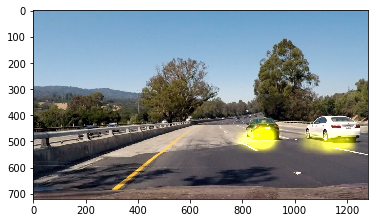

In [11]:
si = StillImage()
si.load_classifier()
si.load_file('test_images/test4.jpg')
cp = si.car_points_heatmap(20, (100,100,0))
plt.imshow(si.overlay(cp, 1.0))

### Heat Map Combinations

This class combines the temporal intensity heat maps to produce the spatio-temporal representation of a likelihood of a vehicle at a certain point.  The spatio-temporal data is implicitly projected to the two dimensional plane of the frame.  In order to qualify as an identified region (filled countour from a binary image determined from the heat map), the heat map region must have a value greater than `min_bound`, a countour area greater than `min_area`, and be in the top `rect_limit` regions by area.  The latter is present since in this assignment we have a priori knowledge of the maximum number of car threats, and can reduce errors by ranking by detection size and limiting to this number.

In [7]:
class OverlayFrameCombiner:
    
    def __init__(self, num_frames, height, width):
        self.num_frames = num_frames
        self.frames = []
        self.height = height
        self.width = width
        
    def add_frame(self, frame):
        self.frames.append(frame)
        self.frames = self.frames[-self.num_frames:]

    def rectangles(self, min_bound, min_area, rect_limit):
        centers = []
        bounding_boxes = []
        image = np.zeros((self.height, self.width, 3), np.uint8)
        combined = np.zeros((self.height, self.width), np.uint8)
        for f in self.frames:
            cv2.addWeighted(f, 1.0, combined, 1.0, 0, combined)
        threshold = cv2.threshold(combined, min_bound, 255, cv2.THRESH_BINARY)
        contours = cv2.findContours(threshold[1].copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours = sorted(contours[1], key=cv2.contourArea, reverse=True)
        for c in contours:
            area = cv2.contourArea(c)
            if area > min_area:
                bb = cv2.boundingRect(c)
                center = (bb[0] + bb[2] / 2, bb[1] + bb[3] / 2)
                centers.append(center)
                bounding_boxes.append(bb)
        return (centers[:rect_limit], bounding_boxes[:rect_limit])
    
    def rectangle_overlay(self, image, bounding_boxes, color):
        overlay = np.zeros((self.height, self.width, 3), np.uint8)
        for bb in bounding_boxes:
            cv2.rectangle(overlay, (bb[0], bb[1]), (bb[0] + bb[2], bb[1] + bb[3]), color, 3)
        return overlay

### Vehicle Tracking

Vehicle tracking is done using both the `PointTracker` and `ObjectTracker` classes.  The first class is simply helpful in implementing the second.  

The idea of the system is that new points representing detected car locations are fed to the system.  If the point is within some threshold distance of a known point then we will add the new point to that point.  Once all such new points are exhausted, if there are any left that were not added we create a new instance of a `PointTracker` object for the new point.  Any existing points that were not updated with new points are updated with `None` to signify that they did not have a detection.  At this point all of the tracked points are evaluated for fitness to continue existing, which is based on whether or not in a maximum number of tracked events they have more than a specified number of non-existant entries.  These points are culled.  If the remaining tracked points have more than a specified number of valid locations registered, the average over all of the registered locations for that point is returned.  Using this system, the average is returned if there is enough to average, and the point is culled from the system if there are too many instances of not meeting the criteria of a new point being within the distance tolerance.

In [ ]:
class PointTracker:
    
    TOTAL_POINTS = 30
    IS_VALID_POINTS = 15
    IS_SHOWN_POINTS = 15
    
    def __init__(self, center):
        self.updated = True
        self.centers = [center]
   
    def reset_update(self):
        self.updated = False

    def update(self, center):
        self.centers.append(center)
        self.centers = self.centers[-self.TOTAL_POINTS:]
        self.updated = True
        
    def is_valid(self):
        if self.centers.count(None) > self.IS_VALID_POINTS:
            return False
        else:
            return True
    
    def is_shown(self):
        if len(self.centers) - self.centers.count(None) > self.IS_SHOWN_POINTS:
            return True
        else:
            return False
    
    def center_average(self):
        total = len(self.centers) - self.centers.count(None)
        total_x = 0
        total_y = 0
        for c in self.centers:
            if c != None:
                total_x += c[0]
                total_y += c[1]
        return (int(total_x / total), int(total_y / total))
    
    
class ObjectTracker:
    
    def __init__(self, distance):
        self.objects = []
        self.distance = distance
        
    def is_close(self, a, b):
        dx = a[0] - b[0]
        dy = a[1] - b[1]
        d = math.sqrt(dx**2 + dy**2)
        if d < self.distance:
            return True
        else:
            return False
        
    def new_data(self, rectangles):
        rect = rectangles
        for p in self.objects:
            p.reset_update()
        for r in list(rect):
            for o in self.objects:
                if self.is_close(r, o.center_average()) and o.updated == False:
                    o.update(r)
                    rect.remove(r)
        for r in rect:
            self.objects.append(PointTracker(r))
        for o in self.objects:
            if o.updated == False:
                o.update(None)
        new_objects = []
        for o in self.objects:
            if o.is_valid():
                new_objects.append(o)
        self.objects = new_objects
        result = []
        for o in self.objects:
            if o.is_shown():
                result.append(o.center_average())
        return result


### Bounding Box

I tried a variety of ways of building a bounding box around a car that is based on an estimated center of the vehicle.  Some of the approaches were clustering the marginal counts from a Sobel frame, and using a Sobel frame to define countours and then selecting the longest ones as a means of identifying the outer contour of the vehicle.  These did not work as reliably as the one presented below, which uses image moments after selecting colors and keeping the saturation from the HLS color space.  The bounds are determined by using the image moments along with the top percetile results of a marginal histogram based on the pixel counts in the respective direction.  I found that between the `90th` and `95th` percentile worked pretty well, as this rejects the top few that have offshoots beyond the car and the vast bulk of the lower counts that represent missing parts of the car image from the procedure.  This procedure is also performed in a masked region, as cars near the right of the road have artifacts that skew the bounds from the trees and other similar features.

In [ ]:
class FilteredCentroidBoundingBox:
    
    MASK_REGION = ( (750,600), (750,400), (1280,400), (1280,600) )
    
    LOW_COLOR = (0,0,0)
    HIGH_COLOR = (255,255,255)
    
    THRESHOLD_MIN = 50
    THRESHOLD_MAX = 255
    
    LOW_PERCENTILE = 90
    HIGH_PERCENTILE = 95
    
    def __init__(self, image):
        self.image = image
        self.compute_image = image
        
    def region_of_interest(self, img, vertices):
        mask = np.zeros_like(img)   
        if len(img.shape) > 2:
            channel_count = img.shape[2]  
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255
        cv2.fillPoly(mask, [np.array(vertices)], ignore_mask_color)
        return cv2.bitwise_and(img, mask)

    def select_colors(self, low_value, high_value):
        mask = cv2.inRange(self.compute_image, low_value, high_value)
        self.compute_image = cv2.bitwise_and(self.compute_image, self.compute_image, mask=mask)
    
    def select_mask_region(self, region):
        self.compute_image = self.region_of_interest(self.compute_image, region)
    
    def mutate_colorspace(self):
        hls = cv2.cvtColor(self.compute_image, cv2.COLOR_RGB2HLS)
        s = hls[:,:,2]
        self.compute_image = s
        
    def select_region(self, region):
        self.compute_image = self.compute_image[region[0][0]:region[0][1],region[1][0]:region[1][1]]
    
    def scale_and_threshold(self, threshold_min, theshold_max):
        scale = np.max(self.compute_image) / 255.0
        self.compute_image = (self.compute_image / scale).astype(np.uint8)
        _, self.compute_image = cv2.threshold(self.compute_image, threshold_min, theshold_max, cv2.THRESH_BINARY)
    
    def compute_centroid(self):
        m = cv2.moments(self.compute_image)
        x = int(m["m10"] / m["m00"])
        y = int(m["m01"] / m["m00"])
        return (x, y)
    
    def compute_weighted_marginal(self, axis):
        data = np.sum(self.compute_image, axis=axis) / 255
        data = np.sort(data)
        length = len(data)
        low = int(length * (self.LOW_PERCENTILE - 100) / 100)
        high = int(length * (self.HIGH_PERCENTILE - 100) / 100)
        data = data[low:high]
        return np.average(data)
    
    def get_bbox(self, center_estimate, bounds):
        self.select_colors(self.LOW_COLOR, self.HIGH_COLOR)
        self.select_mask_region(self.MASK_REGION)
        self.mutate_colorspace()
        x_range = (center_estimate[0] - bounds[0], center_estimate[0] + bounds[0])
        y_range = (center_estimate[1] - bounds[1], center_estimate[1] + bounds[1])
        region = (x_range, y_range)
        self.select_region(region)
        self.scale_and_threshold(self.THRESHOLD_MIN, self.THRESHOLD_MAX)
        center = self.compute_centroid()
        x = self.compute_weighted_marginal(1)
        y = self.compute_weighted_marginal(0)
        x1 = int(center[0] - x / 2 + center_estimate[1] - bounds[0])
        x2 = int(center[0] + x / 2 + center_estimate[1] - bounds[0])
        y1 = int(center[1] - y / 2 + center_estimate[0] - bounds[1])
        y2 = int(center[1] + y / 2 + center_estimate[0] - bounds[1])
        return (x1,y1,x2-x1,y2-y1)
 

### Vehicle Detector

This is the class that runs it all.  A lot of hyperparameters are set in this class having to do with the spatio-temporal heat map mechanism, the bounding box parameters and the visual presentation.  It is pretty basic: it goes through the frames and performs the `process_frame` method on each frame using the supplemental functionality to add the proper overlays.  The reason for the indexing of the frames and the conditional frame application is so that it is easier to process sections of the video to further tune parameters.

In [21]:
class VehicleDetector:
    
    FRAME_WIDTH = 1280
    FRAME_HEIGHT = 720
    
    OVERLAY_FRAMES = 7
    
    PLOT_HEATMAP_COLOR = (100,100,0)
    PLOT_HEATMAP_SIZE = 20
    
    COMPUTE_HEATMAP_INTENSITY = 20
    COMPUTE_HEATMAP_SIZE = 35
    
    RECTANGLE_LIMIT = 2
    RECTANGLE_MIN_INTENSITY = 60
    RECTANGLE_MIN_AREA = 7000
    
    BOUNDING_BOX_COLOR = (255,0,0)
    
    OBJECT_TRACKER_DISTANCE = 100
    
    HEATMAP_ALPHA = 0.4
    
    INITIAL_BOUNDS = (100,100)
    
    def __init__(self):
        self.si = StillImage()
        self.si.load_classifier()
        self.ofc = OverlayFrameCombiner(self.OVERLAY_FRAMES, self.FRAME_HEIGHT, self.FRAME_WIDTH)
        self.ot = ObjectTracker(self.OBJECT_TRACKER_DISTANCE)
        
    def process_frame(self, frame):
        self.si.load_image(frame)
        car_points_heatmap = self.si.car_points_heatmap(self.PLOT_HEATMAP_SIZE, self.PLOT_HEATMAP_COLOR)
        intensity_heatmap = self.si.intensity_heatmap(self.COMPUTE_HEATMAP_SIZE, self.COMPUTE_HEATMAP_INTENSITY)
        self.ofc.add_frame(intensity_heatmap)
        rectangles = self.ofc.rectangles(self.RECTANGLE_MIN_INTENSITY, self.RECTANGLE_MIN_AREA, self.RECTANGLE_LIMIT)
        centers = self.ot.new_data(rectangles[0])
        rect = []
        for c in centers:
            fcbb = FilteredCentroidBoundingBox(frame)
            bb = fcbb.get_bbox((c[1],c[0]), self.INITIAL_BOUNDS)
            rect.append(bb)
        rectangles = self.ofc.rectangle_overlay(frame, rect, self.BOUNDING_BOX_COLOR)
        self.si.overlay(car_points_heatmap, self.HEATMAP_ALPHA)
        return self.si.overlay(rectangles, 1.0)
        
    def run(self, input_filename, output_filename):
        video = VideoFileClip(input_filename)
        output_frames = []
        for i, frame in tqdm.tqdm(enumerate(video.iter_frames())):
            if i >= 0 and i < 1300:
                new_frame = self.process_frame(frame)
                output_frames.append(new_frame)
        new_video = ImageSequenceClip(output_frames, fps=video.fps)
        new_video.write_videofile(output_filename, audio=False)
        
    
vd = VehicleDetector()
vd.run('test_videos/project_video.mp4', 'project_output.mp4')


1260it [9:11:02, 27.24s/it]

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4



100%|██████████| 1260/1260 [00:23<00:00, 54.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

